# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

In [1]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

The input file is the ZIP file that is or will be added to each release.

The ZIP file can be generated by running:

```shell
python3 -m ppktstore package --notebook-dir notebooks --output all_phenopackets
```

assuming `ppktstore` has been installed into the active environment, and `notebooks` points to the folder with Phenopacket store notebook directory.

In [2]:
from ppktstore.model import PhenopacketStore

input_zip = 'all_phenopackets.zip'
store = PhenopacketStore.from_release_zip(input_zip)

In [3]:
from ppktstore.stats import PPKtStoreStats

stats = PPKtStoreStats(store)

In [4]:
df = stats.get_summary_df()
df.head(2)

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID,cohort,filename
0,Jacobsen syndrome,OMIM:147791,80,telomeric 11q deletion,chromosomal_deletion,,PMID:15266616,11q_terminal_deletion,all_phenopackets.zip/all_phenopackets/11q_terminal_deletion/PMID_15266616_80.json
1,Jacobsen syndrome,OMIM:147791,128,telomeric 11q deletion,chromosomal_deletion,,PMID:15266616,11q_terminal_deletion,all_phenopackets.zip/all_phenopackets/11q_terminal_deletion/PMID_15266616_128.json


In [5]:
stats_d = stats.get_descriptive_stats()
items = list()
for k,v in stats_d.items():
    items.append({"item": k, "value": v})
df = pd.DataFrame(items)
df.head(30)

Got 3213 unique HPOs


,item,value
0,version,0.1.15
1,phenopackets,5832
2,diseases,467
3,genes,409
4,alleles,3462
5,PMIDs,865
6,individuals per disease (max),463
7,individuals per disease (min),1
8,individuals per disease (mean),12.488223
9,individuals per disease (median),4.0


# Display distribution of counts of phenopackets per disease

In [6]:
counts_per_disease = stats.get_counts_per_disease_df()
counts_per_disease.head(2)

,disease,count
0,OMIM:147791,69
1,OMIM:148600,3


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_with_max(
    disease_counts: pd.Series,
    max_val: int,
    ax: mpl.axes.Axes,
):
    assert (
        isinstance(max_val, int) and max_val > 0
    ), "`max_val` must be a positive `int`"

    bins = list(range(1, max_val + 1)) + [disease_counts.max() + 1]
    labels = list(map(str, bins[:-2])) + [f"≥{max_val}"]
    cats = pd.cut(
        x=disease_counts,
        bins=bins,
        labels=labels,
        right=False,
    )
    cat_count = cats.value_counts().sort_index()
    ax.bar(x=cat_count.index, height=cat_count.values)
    ax.set(
        xlabel="Number of cases",
        xlim=(-0.5, len(labels) - 0.5),
        ylabel="Disease count",
    )
    ax.xaxis.set(major_locator=mpl.ticker.MultipleLocator(1))
    ax.grid(axis="y")

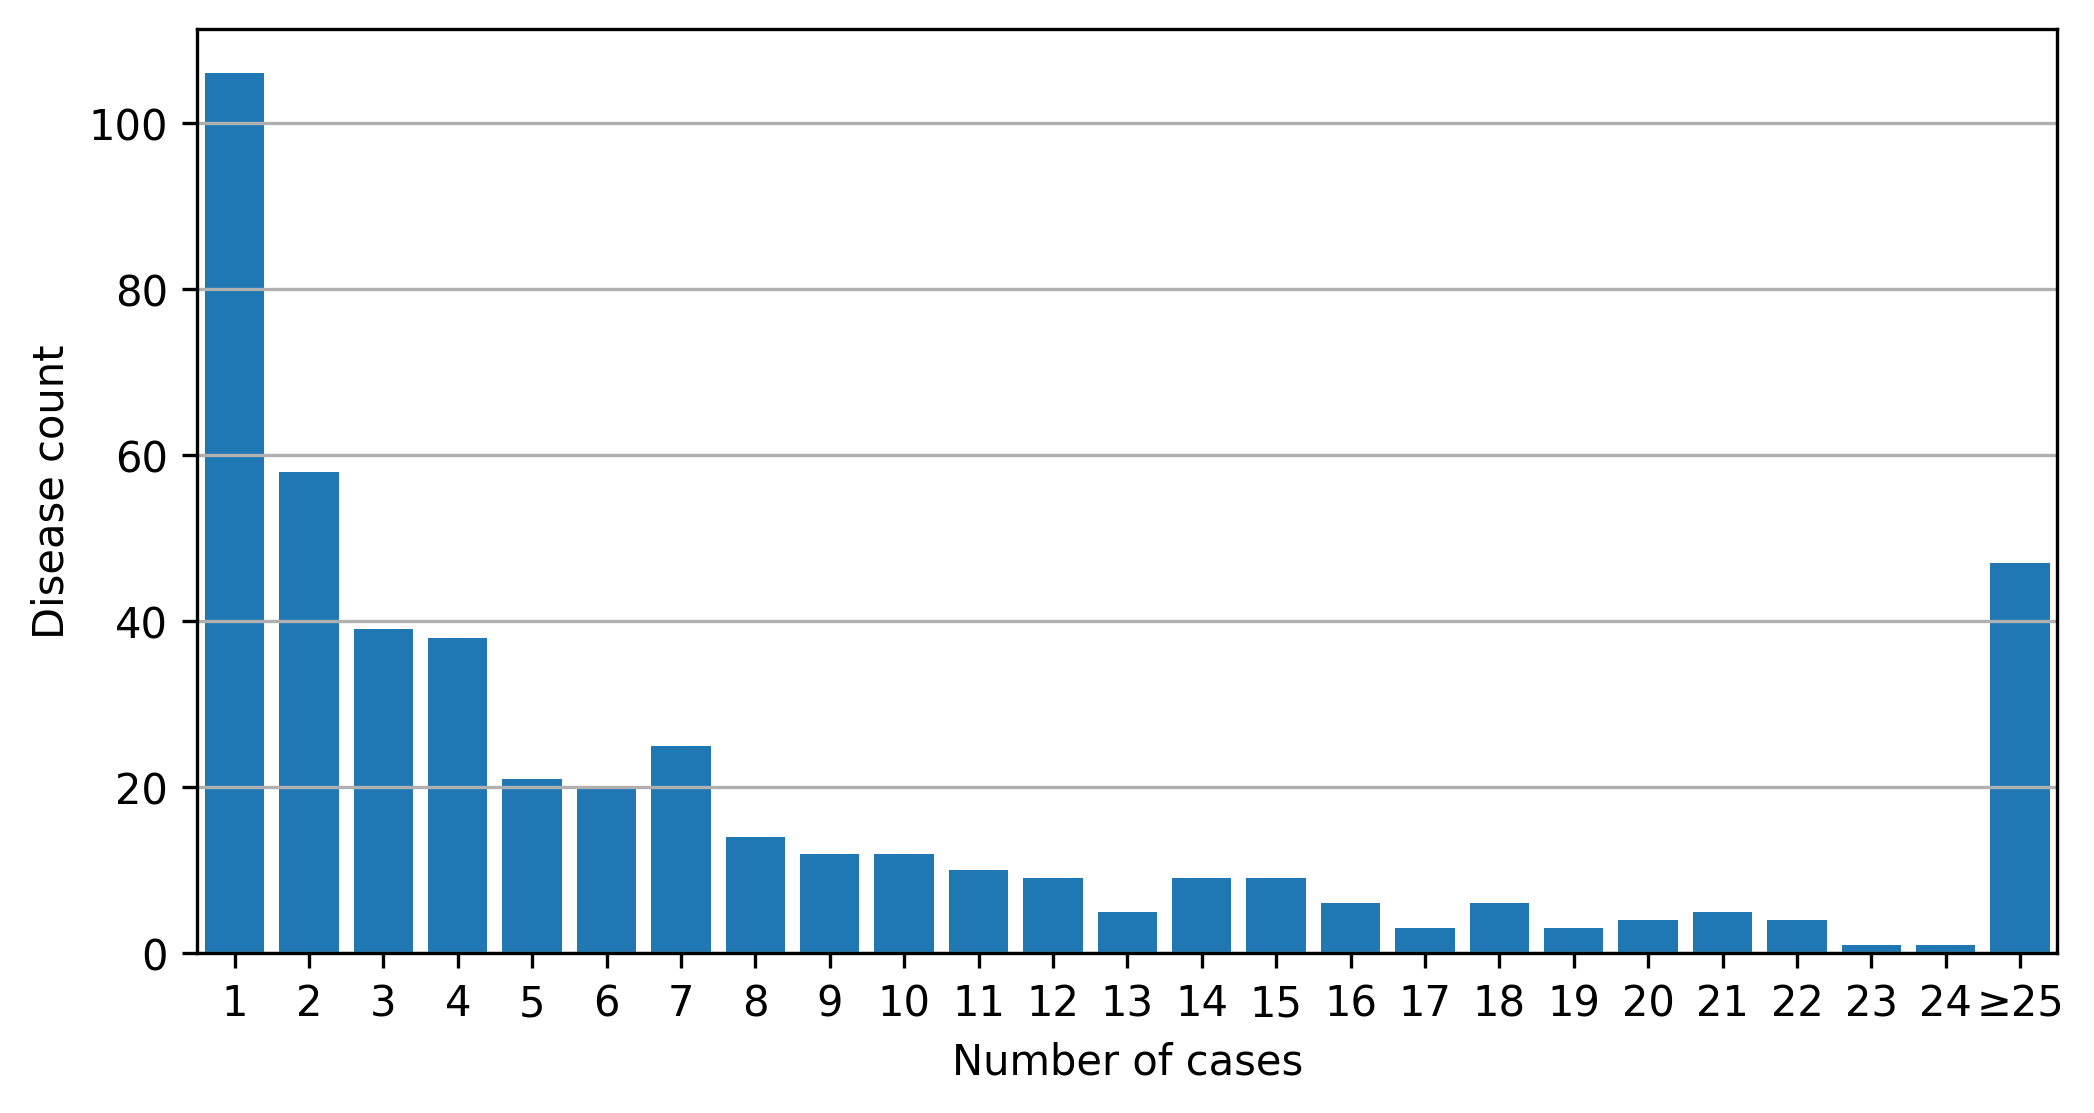

In [8]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
plot_with_max(
    disease_counts=counts_per_disease["count"],
    max_val=25,
    ax=ax
)

# Check all disease identifiers
They should all be CURIEs with the prefixes OMIM or MONDO. There should be no whitespace between the colon and the suffix.

In [9]:
_ = stats.check_disease_id()

No problems found.


# Check for duplicates
In some cases, duplicate phenopackets were inadvertently added to some of the initial cohorts at earlier stages of the project. This function lists phenopacket identifers arranged according to variant and allows us to more easily check for this kind of error.

In [10]:
_ = stats.show_possible_duplicates_by_variant("ERI1")

No candidate duplicates found for ERI1


# Quality control
The following commands perform several consistency checks.

In [11]:
_ = stats.find_phenopackets_with_no_variants()

All phenopackets had at least one variant


In [12]:
_ = stats.show_possible_duplicates_by_variant( "ARPC5")

No candidate duplicates found for ARPC5


In [13]:
_ = stats.find_phenopackets_with_no_disease()

All phenopackets had a disease diagnosis
